<a href="https://colab.research.google.com/github/FrednadFari/Dental-Image-Classification-CNN-nad-ResNet50/blob/main/Dental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os

zip_path = '/content/Mendeley dataset 19.4.2024.zip'
extract_path = '/content/Mendely_photos'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

print("Unzipped Successfully")

Unzipped Successfully


In [2]:
# List all files in /content
for f in os.listdir('/content'):
  print(f)

.config
Mendely_photos
Mendeley dataset 19.4.2024.zip
sample_data


In [3]:
# See the categories
# List the extracted categories
categories = os.listdir("/content/Mendely_photos/Mendeley dataset 19.4.2024/Teeth or Dental Image Dataset")
print("Categories found:", categories)

Categories found: ['Upper Front', 'Upper Left', 'Upper Right', 'Lower Left', 'Lower Occlusal', 'Lower Right', 'Lower Front', 'Upper Occlusal']


Total images: 9562
label
Lower Left        1566
Lower Right       1401
Upper Left        1289
Upper Right       1143
Upper Occlusal    1140
Upper Front       1075
Lower Occlusal    1022
Lower Front        926
Name: count, dtype: int64


/tmp/ipython-input-3527013499.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby('label').apply(lambda x: x.sample(3)).reset_index(drop=True)


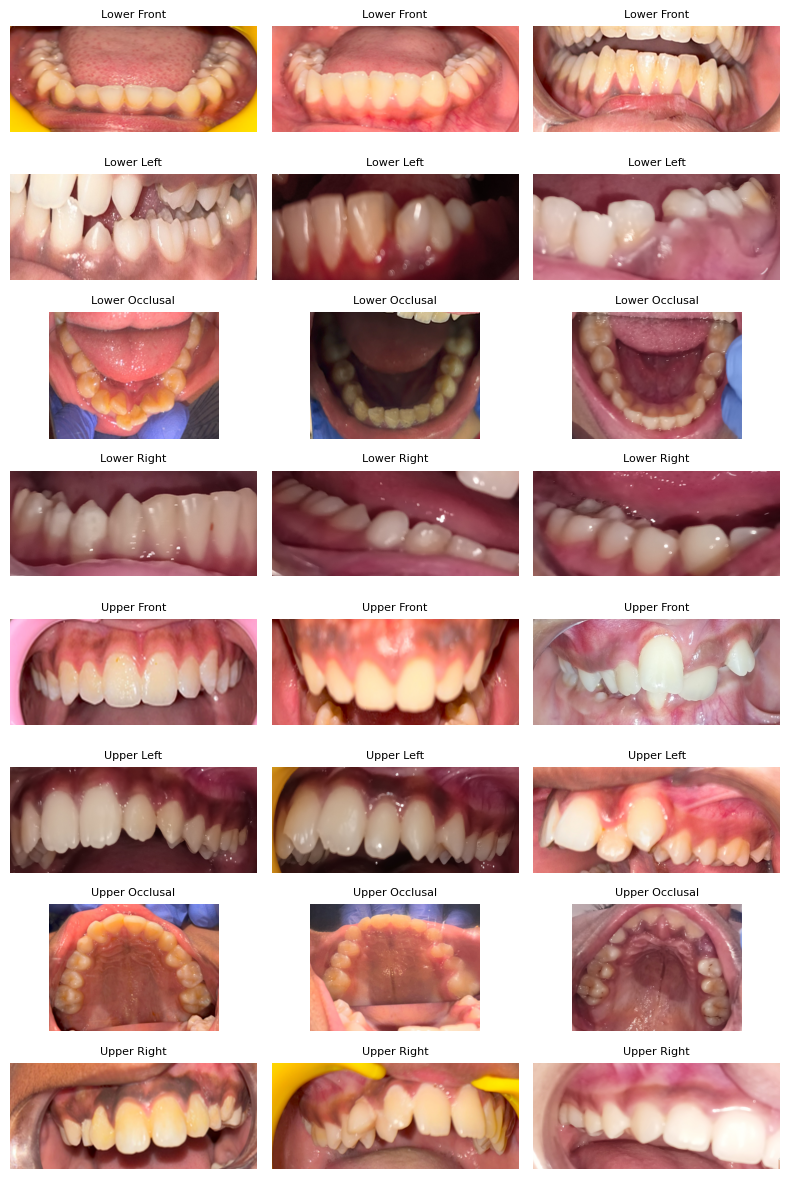

In [4]:
import pandas as pd
from glob import glob
# glob module: standard python library that provides a function for finding pathenames matching a specified pattern, similar to the rules used by the Unix shell.

base_dir = "/content/Mendely_photos/Mendeley dataset 19.4.2024/Teeth or Dental Image Dataset"

# Build DataFrame
data =[]
for category in os.listdir(base_dir):
  category_path = os.path.join(base_dir, category)
  for img_path in glob(os.path.join(category_path, "*")):
    data.append({"filepath": img_path,"label": category})


df = pd.DataFrame(data)
print("Total images:", len(df))
print(df['label'].value_counts())

# Example visualization
import matplotlib.pyplot as plt
import random
sample_df = df.groupby('label').apply(lambda x: x.sample(3)).reset_index(drop=True)

fig, axes = plt.subplots(8, 3, figsize=(8, 12))
for i, (idx, row) in enumerate(sample_df.iterrows()):
    ax = axes[i // 3, i % 3]
    img = plt.imread(row.filepath)
    ax.imshow(img)
    ax.set_title(row.label, fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

| Class          | Count |
| -------------- | ----- |
| Lower Left     | 1,566 |
| Lower Right    | 1,401 |
| Upper Left     | 1,289 |
| Upper Right    | 1,143 |
| Upper Occlusal | 1,140 |
| Upper Front    | 1,075 |
| Lower Occlusal | 1,022 |
| Lower Front    | 926   |


The imbalance isn't extreme (max class~1.7x bigger than min class)
* for this range, weighted loss(WeightedRandomSampler) during training will likly be enough(No need for aggressive oversampling)
* We can keep all of them, but we want to do it for 50% at first to make it faster runs

In [5]:
df.describe()

,filepath,label
count,9562,9562
unique,9562,8
top,/content/Mendely_photos/Mendeley dataset 19.4....,Lower Left
freq,1,1566


## Stratified Train/Val/Test Split

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

# First split--> Train/Val vs Test
train_val_df, test_df = train_test_split(
    df,
    test_size = 0.15, # 15% test
    stratify = df['label'], # preserve class ratio
    random_state = 42
)

# Second split: Train vs Val
train_df, val_df = train_test_split(
    train_val_df,
    test_size = 0.15, # 15% train+val goes to val (~12% of total)
    stratify = train_val_df['label'],
    random_state = 42
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 6907 | Val: 1220 | Test: 1435


compute weights inversely proportional to class frequency — rarer classes get higher weights.

In [7]:
import torch

class_counts = train_df['label'].value_counts().sort_index()  # sorted by label name
class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float32)
class_weights = class_weights / class_weights.sum()  # normalize

print("Class weights:", class_weights)

Class weights: tensor([0.1572, 0.0930, 0.1423, 0.1039, 0.1354, 0.1130, 0.1278, 0.1275])


NOTE: These weights can be passed into:


* loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

Orientation-Safe Augmentations
Since we can’t flip teeth left↔right or up↔down:

In [8]:
import os, math, time, copy, json
from typing import Dict, Tuple
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
import torchvision.transforms as T
# Safety--> Define tfms / dataset if missing
try:
  _ = train_tfms  #type:Ignore
  _ = val_tfms
except NameError:
    import torchvision.transforms as T
    IMG_SIZE = 224
    train_tfms = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.RandomRotation(degrees=10),
        T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        T.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    val_tfms = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

class DFImageDataset(Dataset):
    def __init__(self, df, tfms=None, label_to_idx=None):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms
        self.label_to_idx = label_to_idx
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row.filepath).convert('RGB')
        if self.tfms:
            img = self.tfms(img)
        label_idx = self.label_to_idx[row.label]
        return img, label_idx


In [10]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', DEVICE)

Using device: cuda


In [11]:
def seed_everything(seed=42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(42)

In [12]:
# Map labels if missing
try:
    _ = label_to_idx
    _ = labels_sorted
except NameError:
    labels_sorted = sorted(df['label'].unique())
    label_to_idx = {lbl: i for i, lbl in enumerate(labels_sorted)}

NUM_CLASSES = len(labels_sorted)

In [13]:
def make_class_weights(train_ref_df):
    counts = (train_ref_df['label'].value_counts()
              .reindex(labels_sorted)
              .fillna(0)
              .astype(int))
    w = 1.0 / torch.tensor(counts.values, dtype=torch.float32)
    w = w / w.sum()
    return w

In [17]:
def build_loaders(use_subset: bool = True,
                  use_sampler: bool = False,
                  batch_size: int = 32,
                  num_workers: int = 2,
                  subset_fraction: float = 0.5):
    # pick which dfs to use
    if use_subset and ('train_sub' in globals()) and ('val_sub' in globals()):
        tr_df = train_sub
        va_df = val_sub
    elif use_subset:
        # create on the fly
        grouped = train_df.groupby('label', group_keys=False)
        tr_df = grouped.apply(lambda x: x.sample(max(1, int(len(x)*subset_fraction)), random_state=42)).reset_index(drop=True)
        grouped_v = val_df.groupby('label', group_keys=False)
        va_df = grouped_v.apply(lambda x: x.sample(max(1, int(len(x)*subset_fraction)), random_state=42)).reset_index(drop=True)
    else:
        tr_df = train_df
        va_df = val_df

    # datasets
    tr_ds = DFImageDataset(tr_df, tfms=train_tfms, label_to_idx=label_to_idx)
    va_ds = DFImageDataset(va_df, tfms=val_tfms,   label_to_idx=label_to_idx)

    # balancing
    class_weights = make_class_weights(tr_df)
    sampler = None
    if use_sampler:
        sample_weights = tr_df['label'].map(lambda lbl: class_weights[label_to_idx[lbl]].item()).tolist()
        sampler = WeightedRandomSampler(weights=sample_weights,
                                        num_samples=len(sample_weights),
                                        replacement=True)

    # loaders
    tr_loader = DataLoader(tr_ds, batch_size=batch_size,
                           shuffle=(sampler is None), sampler=sampler,
                           num_workers=num_workers, pin_memory=True)
    va_loader = DataLoader(va_ds, batch_size=batch_size,
                           shuffle=False, num_workers=num_workers, pin_memory=True)

    return tr_loader, va_loader, class_weights, tr_df, va_df


In [18]:
# Small Custom CNN (baseline)
# ~1.2M parameters, BatchNorm + Dropout, GAP head
# ---------------------------
class SmallCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        def conv_bn(in_ch, out_ch, k=3, s=1, p=1):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, k, s, p, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.SiLU(inplace=True),
            )
        self.stem = conv_bn(3, 32, k=3, s=2, p=1)   # 112x112
        self.layer1 = nn.Sequential(
            conv_bn(32, 64),
            nn.Conv2d(64, 64, 3, 2, 1, bias=False), # 56x56
            nn.BatchNorm2d(64), nn.SiLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            conv_bn(64, 128),
            nn.Conv2d(128,128,3,2,1,bias=False),     # 28x28
            nn.BatchNorm2d(128), nn.SiLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            conv_bn(128,256),
            nn.Conv2d(256,256,3,2,1,bias=False),     # 14x14
            nn.BatchNorm2d(256), nn.SiLU(inplace=True),
        )
        self.dropout = nn.Dropout(p=0.3)
        self.head = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = F.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
        x = self.dropout(x)
        return self.head(x)

In [19]:
# Training & Evaluation helpers
# ---------------------------

def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                class_weights: torch.Tensor = None,
                epochs: int = 20,
                lr: float = 3e-4,
                weight_decay: float = 1e-4,
                out_path: str = 'best_model.pt',
                use_amp: bool = True,
                scheduler_type: str = 'cosine',
                early_stop_patience: int = 5) -> Dict:

    model = model.to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    if scheduler_type == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    else:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    if class_weights is not None:
        loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))
    else:
        loss_fn = nn.CrossEntropyLoss()

    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=='cuda'))

    best_state = None
    best_val_acc = -1.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    patience = 0

    for epoch in range(1, epochs+1):
        # Train
        model.train()
        tot, correct, loss_sum = 0, 0, 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(use_amp and DEVICE=='cuda')):
                logits = model(xb)
                loss = loss_fn(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            loss_sum += loss.item()*xb.size(0)
            correct += (logits.argmax(1) == yb).sum().item()
            tot += xb.size(0)
        train_loss = loss_sum / tot
        train_acc = correct / tot

        # Val
        model.eval()
        v_tot, v_correct, v_loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb)
                v_loss = loss_fn(logits, yb)
                v_loss_sum += v_loss.item()*xb.size(0)
                v_correct += (logits.argmax(1) == yb).sum().item()
                v_tot += xb.size(0)
        val_loss = v_loss_sum / v_tot
        val_acc = v_correct / v_tot

        scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch:02d} | train_loss {train_loss:.4f} acc {train_acc:.3f} | val_loss {val_loss:.4f} acc {val_acc:.3f}")

        # Early stopping & checkpoint
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())
            torch.save({'model': best_state,
                        'labels_sorted': labels_sorted}, out_path)
            patience = 0
        else:
            patience += 1
            if patience >= early_stop_patience:
                print('Early stopping triggered.')
                break

    # load best
    if best_state is not None:
        model.load_state_dict(best_state)
    return {'model': model, 'history': history, 'best_val_acc': best_val_acc}

In [20]:
def evaluate(model: nn.Module, loader: DataLoader) -> Dict:
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            logits = model(xb)
            y_true.extend(yb.numpy().tolist())
            y_pred.extend(logits.argmax(1).cpu().numpy().tolist())
    report = classification_report(y_true, y_pred, target_names=labels_sorted, digits=4, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    return {'report': report, 'cm': cm}

In [21]:
def plot_history(history: Dict):
    epochs = range(1, len(history['train_loss'])+1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='train')
    plt.plot(epochs, history['val_loss'], label='val')
    plt.title('Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='train')
    plt.plot(epochs, history['val_acc'], label='val')
    plt.title('Accuracy'); plt.legend()
    plt.tight_layout(); plt.show()

In [22]:
def plot_confusion_matrix(cm: np.ndarray, class_names):
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout(); plt.show()

Experiment 1: Baseline Small CNN on ~50% data ("BaseModel")


==== Experiment 1: SmallCNN on subset (BaseModel) ====


/tmp/ipython-input-1981490841.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tr_df = grouped.apply(lambda x: x.sample(max(1, int(len(x)*subset_fraction)), random_state=42)).reset_index(drop=True)
/tmp/ipython-input-1981490841.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  va_df = grouped_v.apply(lambda x: x.sample(max(1, int(len(x)*subset_fraction)), random_state=42)).reset_index(drop=True)
/tmp

Epoch 01 | train_loss 1.4812 acc 0.416 | val_loss 1.2186 acc 0.568
Epoch 02 | train_loss 1.0413 acc 0.593 | val_loss 0.8077 acc 0.727
Epoch 03 | train_loss 0.7907 acc 0.745 | val_loss 0.5900 acc 0.801
Epoch 04 | train_loss 0.5628 acc 0.841 | val_loss 0.4124 acc 0.895
Epoch 05 | train_loss 0.4376 acc 0.878 | val_loss 0.3805 acc 0.878
Epoch 06 | train_loss 0.3254 acc 0.918 | val_loss 0.2928 acc 0.923
Epoch 07 | train_loss 0.2577 acc 0.942 | val_loss 0.1912 acc 0.961
Epoch 08 | train_loss 0.2192 acc 0.946 | val_loss 0.1846 acc 0.941
Epoch 09 | train_loss 0.1836 acc 0.959 | val_loss 0.1697 acc 0.957
Epoch 10 | train_loss 0.1780 acc 0.960 | val_loss 0.1295 acc 0.970
Epoch 11 | train_loss 0.1404 acc 0.972 | val_loss 0.1219 acc 0.962
Epoch 12 | train_loss 0.1191 acc 0.974 | val_loss 0.1008 acc 0.974
Epoch 13 | train_loss 0.1038 acc 0.979 | val_loss 0.1082 acc 0.966
Epoch 14 | train_loss 0.0907 acc 0.984 | val_loss 0.0987 acc 0.972
Epoch 15 | train_loss 0.0826 acc 0.986 | val_loss 0.0754 acc 0

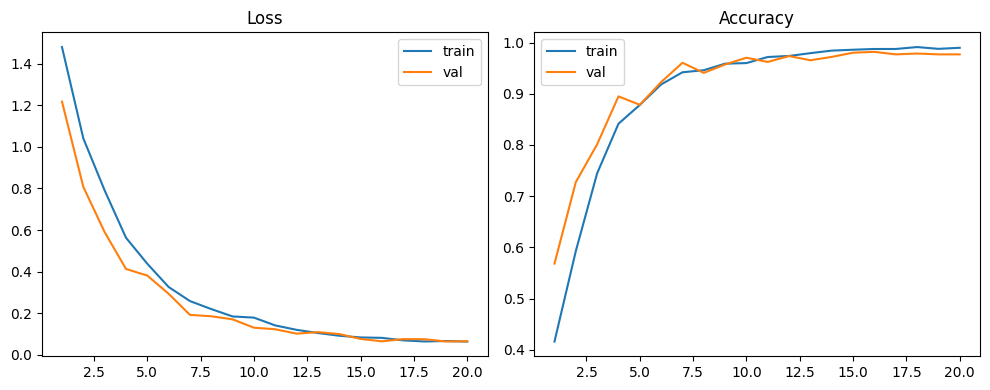

In [23]:
print('\n==== Experiment 1: SmallCNN on subset (BaseModel) ====')
train_loader, val_loader, class_weights, tr_df_used, va_df_used = build_loaders(
    use_subset=True, use_sampler=False, batch_size=32, num_workers=2, subset_fraction=0.5)

model_small = SmallCNN(num_classes=NUM_CLASSES)
res1 = train_model(model_small, train_loader, val_loader,
                   class_weights=class_weights,
                   epochs=20, lr=3e-4, weight_decay=1e-4,
                   out_path='best_smallcnn_subset.pt', use_amp=True,
                   scheduler_type='cosine', early_stop_patience=5)
plot_history(res1['history'])

Experiment 2: Small CNN on FULL data


==== Experiment 2: SmallCNN on FULL data ====


/tmp/ipython-input-320195271.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=='cuda'))
/tmp/ipython-input-320195271.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and DEVICE=='cuda')):


Epoch 01 | train_loss 1.2347 acc 0.525 | val_loss 0.8175 acc 0.766
Epoch 02 | train_loss 0.6121 acc 0.821 | val_loss 0.3716 acc 0.893
Epoch 03 | train_loss 0.3449 acc 0.909 | val_loss 0.2142 acc 0.954
Epoch 04 | train_loss 0.2339 acc 0.944 | val_loss 0.1441 acc 0.962
Epoch 05 | train_loss 0.1745 acc 0.959 | val_loss 0.1468 acc 0.958
Epoch 06 | train_loss 0.1567 acc 0.963 | val_loss 0.0972 acc 0.975
Epoch 07 | train_loss 0.1203 acc 0.970 | val_loss 0.0750 acc 0.984
Epoch 08 | train_loss 0.1005 acc 0.976 | val_loss 0.0785 acc 0.977
Epoch 09 | train_loss 0.0811 acc 0.982 | val_loss 0.0803 acc 0.977
Epoch 10 | train_loss 0.0749 acc 0.982 | val_loss 0.0743 acc 0.971
Epoch 11 | train_loss 0.0614 acc 0.986 | val_loss 0.0638 acc 0.980
Epoch 12 | train_loss 0.0536 acc 0.986 | val_loss 0.0530 acc 0.982
Epoch 13 | train_loss 0.0474 acc 0.989 | val_loss 0.0364 acc 0.988
Epoch 14 | train_loss 0.0411 acc 0.990 | val_loss 0.0325 acc 0.993
Epoch 15 | train_loss 0.0341 acc 0.992 | val_loss 0.0262 acc 0

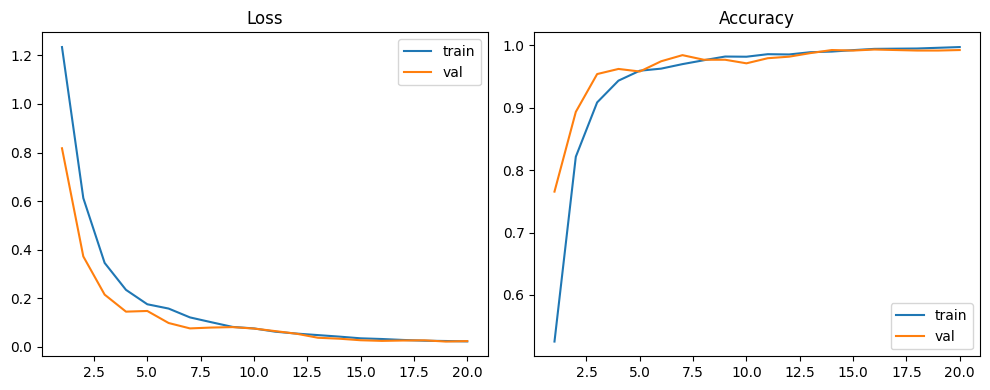

In [24]:
print('\n==== Experiment 2: SmallCNN on FULL data ====')
train_loader_f, val_loader_f, class_weights_f, _, _ = build_loaders(
    use_subset=False, use_sampler=False, batch_size=32, num_workers=2)

model_small_full = SmallCNN(num_classes=NUM_CLASSES)
res2 = train_model(model_small_full, train_loader_f, val_loader_f,
                   class_weights=class_weights_f,
                   epochs=20, lr=3e-4, weight_decay=1e-4,
                   out_path='best_smallcnn_full.pt', use_amp=True,
                   scheduler_type='cosine', early_stop_patience=6)
plot_history(res2['history'])

Experiment 3: ResNet50 fine-tune on FULL data


==== Experiment 3: ResNet50 fine-tune on FULL data ====


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]
/tmp/ipython-input-320195271.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=='cuda'))
/tmp/ipython-input-320195271.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and DEVICE=='cuda')):


Epoch 01 | train_loss 0.4339 acc 0.874 | val_loss 0.0332 acc 0.989
Epoch 02 | train_loss 0.0408 acc 0.989 | val_loss 0.0188 acc 0.994
Epoch 03 | train_loss 0.0239 acc 0.994 | val_loss 0.0172 acc 0.994
Epoch 04 | train_loss 0.0135 acc 0.997 | val_loss 0.0141 acc 0.995
Epoch 05 | train_loss 0.0123 acc 0.996 | val_loss 0.0093 acc 0.997
Epoch 06 | train_loss 0.0111 acc 0.997 | val_loss 0.0122 acc 0.997
Epoch 07 | train_loss 0.0060 acc 0.998 | val_loss 0.0110 acc 0.998
Epoch 08 | train_loss 0.0017 acc 1.000 | val_loss 0.0064 acc 0.998
Epoch 09 | train_loss 0.0039 acc 0.999 | val_loss 0.0139 acc 0.997
Epoch 10 | train_loss 0.0023 acc 0.999 | val_loss 0.0131 acc 0.998
Epoch 11 | train_loss 0.0013 acc 1.000 | val_loss 0.0082 acc 0.998
Epoch 12 | train_loss 0.0013 acc 1.000 | val_loss 0.0110 acc 0.998
Early stopping triggered.


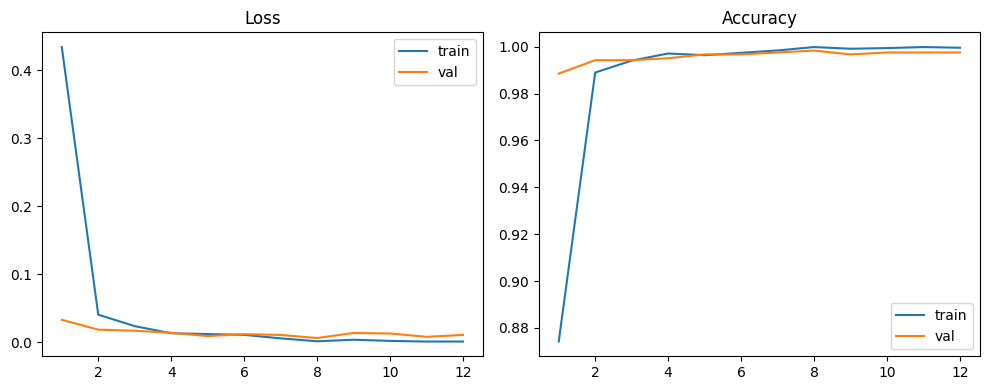

In [25]:
print('\n==== Experiment 3: ResNet50 fine-tune on FULL data ====')
import torchvision as tv

weights = tv.models.ResNet50_Weights.IMAGENET1K_V2
resnet = tv.models.resnet50(weights=weights)
resnet.fc = nn.Linear(resnet.fc.in_features, NUM_CLASSES)

# Smaller LR for pretrained model fine-tuning
res3 = train_model(resnet, train_loader_f, val_loader_f,
                   class_weights=class_weights_f,
                   epochs=15, lr=1e-4, weight_decay=1e-4,
                   out_path='best_resnet50_full.pt', use_amp=True,
                   scheduler_type='cosine', early_stop_patience=4)
plot_history(res3['history'])

Evaluation on VALIDATION (quick check). For final numbers, evaluate on TEST.


SmallCNN (subset) — val macro F1: 0.9815 | val accuracy: 0.9819


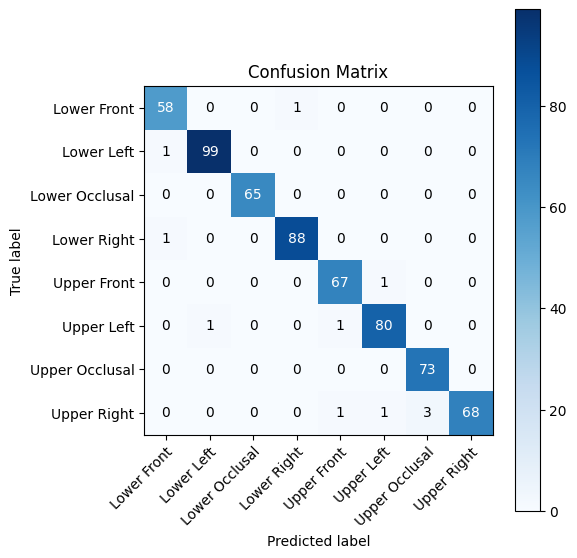


SmallCNN (full) — val macro F1: 0.9934 | val accuracy: 0.9934


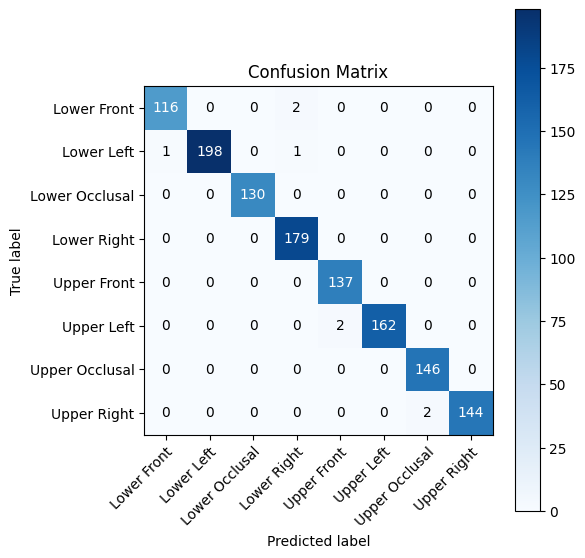


ResNet50 (full) — val macro F1: 0.9985 | val accuracy: 0.9984


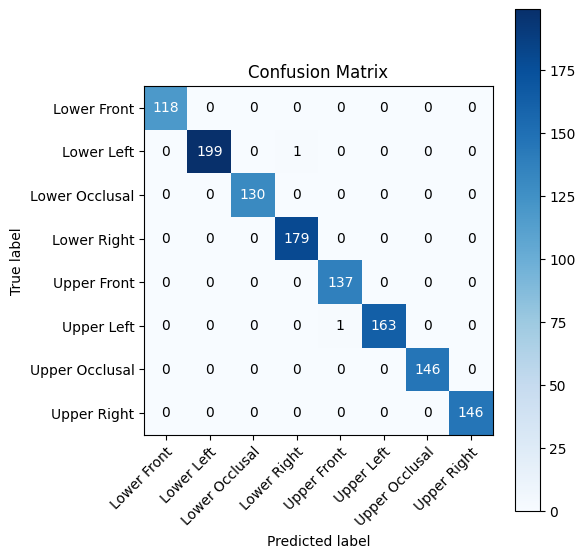

In [26]:
def quick_eval(name, model, loader):
    ev = evaluate(model, loader)
    print(f"\n{name} — val macro F1: {ev['report']['macro avg']['f1-score']:.4f} | val accuracy: {ev['report']['accuracy']:.4f}")
    plot_confusion_matrix(ev['cm'], labels_sorted)

quick_eval('SmallCNN (subset)', res1['model'], val_loader)
quick_eval('SmallCNN (full)',   res2['model'], val_loader_f)
quick_eval('ResNet50 (full)',   res3['model'], val_loader_f)

Final Evaluation on TEST set (after selecting the best model by val)

In [27]:
test_ds = DFImageDataset(test_df, tfms=val_tfms, label_to_idx=label_to_idx)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

Choose the best by validation accuracy


Best by validation: ResNet50_full (val acc 0.9984). Evaluating on TEST…
Test accuracy: 0.9944250871080139
{
  "Lower Front": {
    "precision": 1.0,
    "recall": 0.9784172661870504,
    "f1-score": 0.9890909090909091,
    "support": 139.0
  },
  "Lower Left": {
    "precision": 0.9915611814345991,
    "recall": 1.0,
    "f1-score": 0.9957627118644068,
    "support": 235.0
  },
  "Lower Occlusal": {
    "precision": 1.0,
    "recall": 1.0,
    "f1-score": 1.0,
    "support": 153.0
  },
  "Lower Right": {
    "precision": 0.995260663507109,
    "recall": 1.0,
    "f1-score": 0.997624703087886,
    "support": 210.0
  },
  "Upper Front": {
    "precision": 0.9937106918238994,
    "recall": 0.9813664596273292,
    "f1-score": 0.9875,
    "support": 161.0
  },
  "Upper Left": {
    "precision": 0.9948453608247423,
    "recall": 0.9948453608247423,
    "f1-score": 0.9948453608247423,
    "support": 194.0
  },
  "Upper Occlusal": {
    "precision": 1.0,
    "recall": 1.0,
    "f1-score": 1.0

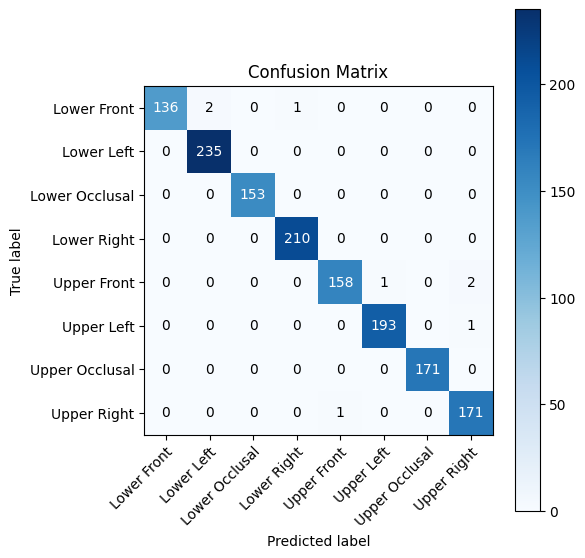

All done. Saved checkpoints: 
 - best_smallcnn_subset.pt
 - best_smallcnn_full.pt
 - best_resnet50_full.pt


In [28]:
best_name, best_model, best_val = None, None, -1
for name, res in [('SmallCNN_subset', res1), ('SmallCNN_full', res2), ('ResNet50_full', res3)]:
    if res['best_val_acc'] > best_val:
        best_name, best_model, best_val = name, res['model'], res['best_val_acc']

print(f"\nBest by validation: {best_name} (val acc {best_val:.4f}). Evaluating on TEST…")

te = evaluate(best_model, test_loader)
print('Test accuracy:', te['report']['accuracy'])
print(json.dumps({k: {m: float(te['report'][k][m]) for m in ['precision','recall','f1-score','support']}
                 for k in labels_sorted+['macro avg','weighted avg']}, indent=2))
plot_confusion_matrix(te['cm'], labels_sorted)

print("All done. Saved checkpoints: \n - best_smallcnn_subset.pt\n - best_smallcnn_full.pt\n - best_resnet50_full.pt")

Let's run a single image inference on the training model.

In [29]:
import torch, torchvision as tv, torch.nn as nn, torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = 224

# Use the *validation* transforms (no flips/strong augments)
val_tfms = tv.transforms.Compose([
    tv.transforms.Resize((IMG_SIZE, IMG_SIZE)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                            std=(0.229, 0.224, 0.225))
])

# If your training script saved "labels_sorted" inside the checkpoint:
def load_labels_from_ckpt(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location='cpu')
    labels_sorted = ckpt.get('labels_sorted', None)
    state_dict = ckpt['model'] if 'model' in ckpt else ckpt
    return labels_sorted, state_dict


In [30]:
# SmallCNN must match the architecture used in training
class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        def conv_bn(in_ch, out_ch, k=3, s=1, p=1):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, k, s, p, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.SiLU(inplace=True),
            )
        self.stem = conv_bn(3, 32, k=3, s=2, p=1)   # 112x112
        self.layer1 = nn.Sequential(
            conv_bn(32, 64),
            nn.Conv2d(64, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.SiLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            conv_bn(64,128),
            nn.Conv2d(128,128,3,2,1,bias=False),
            nn.BatchNorm2d(128), nn.SiLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            conv_bn(128,256),
            nn.Conv2d(256,256,3,2,1,bias=False),
            nn.BatchNorm2d(256), nn.SiLU(inplace=True),
        )
        self.dropout = nn.Dropout(p=0.3)
        self.head = nn.Linear(256, num_classes)
    def forward(self, x):
        import torch.nn.functional as F
        x = self.stem(x); x = self.layer1(x); x = self.layer2(x); x = self.layer3(x)
        x = F.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
        x = self.dropout(x)
        return self.head(x)

def load_smallcnn(ckpt_path):
    labels_sorted, state_dict = load_labels_from_ckpt(ckpt_path)
    assert labels_sorted is not None, "labels_sorted not found in checkpoint"
    model = SmallCNN(num_classes=len(labels_sorted)).to(DEVICE)
    model.load_state_dict(state_dict)
    model.eval()
    return model, labels_sorted

def load_resnet50(ckpt_path):
    labels_sorted, state_dict = load_labels_from_ckpt(ckpt_path)
    assert labels_sorted is not None, "labels_sorted not found in checkpoint"
    resnet = tv.models.resnet50(weights=None)  # we’re loading your fine-tuned weights
    resnet.fc = nn.Linear(resnet.fc.in_features, len(labels_sorted))
    resnet = resnet.to(DEVICE)
    resnet.load_state_dict(state_dict)
    resnet.eval()
    return resnet, labels_sorted


Saving lower_front.jpg to lower_front.jpg
Prediction: Lower Front  (conf: 0.999)


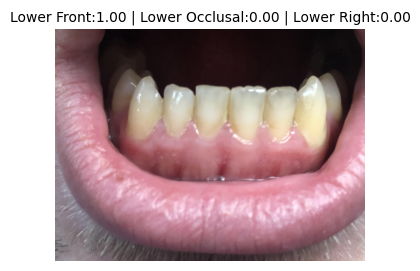

In [38]:
from google.colab import files
import numpy as np

def predict_image(model, labels_sorted, img_path, tta=False):
    img = Image.open(img_path).convert('RGB')
    x = val_tfms(img).unsqueeze(0).to(DEVICE)

    if not tta:
        with torch.no_grad():
            logits = model(x)
        probs = logits.softmax(dim=1).squeeze(0).cpu().numpy()
    else:
        # Safe TTA: small rotations only (no flips)
        angles = [0, -7, 7]
        preds = []
        for a in angles:
            aug = tv.transforms.Compose([
                tv.transforms.Resize((IMG_SIZE, IMG_SIZE)),
                tv.transforms.functional.rotate,
            ])
        # simpler: just apply rotations manually
        logits_accum = 0
        with torch.no_grad():
            for a in angles:
                img_r = img.rotate(a)
                xr = val_tfms(img_r).unsqueeze(0).to(DEVICE)
                logits_accum += model(xr)
        probs = (logits_accum / len(angles)).softmax(dim=1).squeeze(0).cpu().numpy()

    idx = int(np.argmax(probs))
    return labels_sorted[idx], float(probs[idx]), probs

# Upload an image from your machine
uploaded = files.upload()  # choose a real dental photo
img_path = list(uploaded.keys())[0]

# --- Choose which model to test ---
# model, labels_sorted = load_smallcnn('best_smallcnn_full.pt')
model, labels_sorted = load_resnet50('best_resnet50_full.pt')

pred_label, pred_conf, probs = predict_image(model, labels_sorted, img_path, tta=False)
print(f"Prediction: {pred_label}  (conf: {pred_conf:.3f})")

# Show image with title + top-3
topk = 3
top_idx = np.argsort(probs)[::-1][:topk]
plt.figure(figsize=(4,4))
plt.imshow(Image.open(img_path)); plt.axis('off')
title = " | ".join([f"{labels_sorted[i]}:{probs[i]:.2f}" for i in top_idx])
plt.title(title, fontsize=10); plt.show()


Saving Uknown.jfif to Uknown.jfif
Prediction: Upper Occlusal  (conf: 0.999)


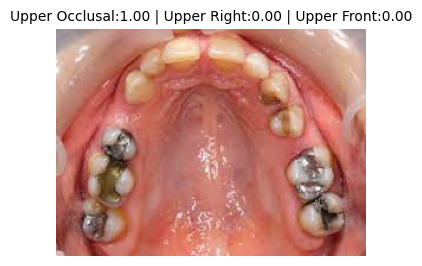

In [32]:
from google.colab import files
import numpy as np

def predict_image(model, labels_sorted, img_path, tta=False):
    img = Image.open(img_path).convert('RGB')
    x = val_tfms(img).unsqueeze(0).to(DEVICE)

    if not tta:
        with torch.no_grad():
            logits = model(x)
        probs = logits.softmax(dim=1).squeeze(0).cpu().numpy()
    else:
        # Safe TTA: small rotations only (no flips)
        angles = [0, -7, 7]
        preds = []
        for a in angles:
            aug = tv.transforms.Compose([
                tv.transforms.Resize((IMG_SIZE, IMG_SIZE)),
                tv.transforms.functional.rotate,
            ])
        # simpler: just apply rotations manually
        logits_accum = 0
        with torch.no_grad():
            for a in angles:
                img_r = img.rotate(a)
                xr = val_tfms(img_r).unsqueeze(0).to(DEVICE)
                logits_accum += model(xr)
        probs = (logits_accum / len(angles)).softmax(dim=1).squeeze(0).cpu().numpy()

    idx = int(np.argmax(probs))
    return labels_sorted[idx], float(probs[idx]), probs

# Upload an image from your machine
uploaded = files.upload()  # choose a real dental photo
img_path = list(uploaded.keys())[0]

# --- Choose which model to test ---
# model, labels_sorted = load_smallcnn('best_smallcnn_full.pt')
model, labels_sorted = load_resnet50('best_resnet50_full.pt')

pred_label, pred_conf, probs = predict_image(model, labels_sorted, img_path, tta=False)
print(f"Prediction: {pred_label}  (conf: {pred_conf:.3f})")

# Show image with title + top-3
topk = 3
top_idx = np.argsort(probs)[::-1][:topk]
plt.figure(figsize=(4,4))
plt.imshow(Image.open(img_path)); plt.axis('off')
title = " | ".join([f"{labels_sorted[i]}:{probs[i]:.2f}" for i in top_idx])
plt.title(title, fontsize=10); plt.show()


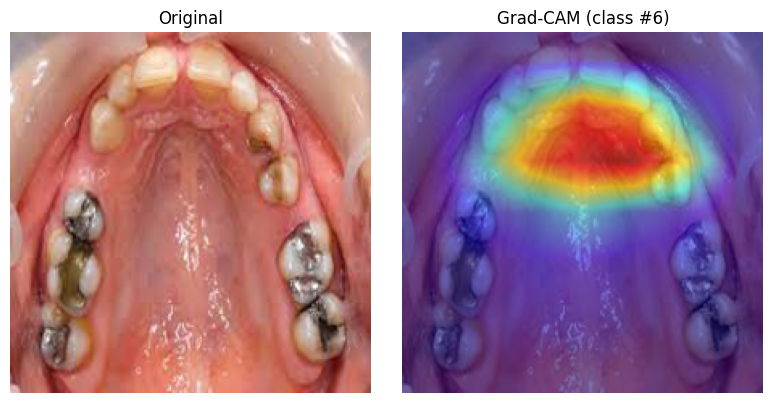

In [34]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt

model.eval()  # important
x = val_tfms(Image.open(img_path).convert('RGB')).unsqueeze(0).to(DEVICE)

# last conv block in ResNet50
target_layers = [model.layer4[-1]]

# If you already predicted, reuse its index; else pick argmax below
with torch.no_grad():
    pred_idx = model(x).argmax(dim=1).item()

# Use context manager to avoid __del__ warnings
with GradCAM(model=model, target_layers=target_layers) as cam:
    targets = [ClassifierOutputTarget(pred_idx)]
    grayscale_cam = cam(input_tensor=x, targets=targets)[0]  # HxW

rgb = np.array(Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))) / 255.0
overlay = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(rgb); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(overlay); plt.title(f"Grad-CAM (class #{pred_idx})"); plt.axis('off')
plt.tight_layout(); plt.show()

In [35]:
# For SmallCNN, point to the last conv layer. You have:
# layer3 = [ conv_bn(128,256), Conv2d(256,256), BatchNorm2d, SiLU ]
target_layers = [model.layer3[1]]  # the Conv2d just before GAP

with GradCAM(model=model, target_layers=target_layers) as cam:
    targets = [ClassifierOutputTarget(pred_idx)]
    grayscale_cam = cam(input_tensor=x, targets=targets)[0]


In [36]:
from pytorch_grad_cam import EigenCAM
with EigenCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=x)[0]